In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import modelos as md
from importlib import reload
reload(md)

<module 'modelos' from 'd:\\rodri\\Programações\\Aprendizado de Maquina\\Reconhecimento-de-digitos-ML-2023.2\\modelos.py'>

In [4]:
dataframe_treino = pd.read_csv('train_redu.csv', sep=';')
dataframe_teste = pd.read_csv('test_reduzido.csv', sep=';')

# Tratamento dos dados

In [5]:
# Funçao para transformar os dados em uma normal 0,1
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

# Obtendo os valores de treino e teste
X = dataframe_treino[['intensidade', 'simetria']].values
X_teste = dataframe_teste[['intensidade', 'simetria']].values
Y = dataframe_treino['label'].values
y_teste = dataframe_teste['label'].values

# Transformando os dados e alterando os valores de label para 1 e -1
X = padronizar_normal(X)
X_teste = padronizar_normal(X_teste)
# Adicionando uma coluna de 1s
X = np.c_[np.ones(len(X)), X]
X_teste = np.c_[np.ones(len(X_teste)), X_teste]

### a confusion_matriz ta com um comportamento estranho, essas celulas foram alguns testes

In [49]:
y_binario = np.where(Y == [0], 1, 0)
y_binario

array([1, 1, 1, ..., 0, 0, 0])

In [50]:
modelo_reg_log = md.RegressaoLogistica(X,y_binario)
modelo_reg_log.fit()
y_pred_treino = modelo_reg_log.atribuicao_de_classes(modelo_reg_log.get_w(),X)
y_pred_treino

array([ 1,  1,  1, ..., -1, -1, -1])

In [51]:
matriz_de_confusao_treino = confusion_matrix(y_binario, y_pred_treino)
print(matriz_de_confusao_treino)
# ????????????????????????????????????? WTF

[[   0    0    0]
 [1761    0    0]
 [  14    0  411]]


In [52]:
model = md.RegressaoLinear()
w = model.fit(X, y_binario)
y_pred_treino2 = model.atribuicao_de_classes(X) 
y_pred_treino2

array([1, 1, 1, ..., 1, 1, 1])

In [56]:
matriz_de_confusao_treino2 = confusion_matrix(y_binario, y_pred_treino2)
matriz_de_confusao_treino2
# até na linear vei ?????????
# mas na 1vs all ta certo, n sei pq

array([[   0,    0,    0],
       [ 549,    0, 1212],
       [   0,    0,  425]], dtype=int64)

In [55]:
print(classification_report(y_binario, y_pred_treino2, target_names=[f'0', '-1']))

ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

# Usando a Regressão Logística

In [61]:
def classificador_de_todos_os_digitos_treinamento_Rlog(X_treino,Y_treino, X_teste, Y_teste, lista_digitos):
    X = X_treino.copy()
    y = Y_treino.copy()
    x_teste = X_teste.copy()
    y_teste = Y_teste.copy()
    w_list = []
    
    for digito in lista_digitos:     
        y_binario = np.where(y == digito, 1, 0)
        y_binario_teste = np.where(y == digito, 1, 0)
        modelo_reg_log = md.RegressaoLogistica(X,y_binario)
        modelo_reg_log.fit()

        y_pred_treino = modelo_reg_log.atribuicao_de_classes(modelo_reg_log.get_w(),X)
        y_pred_teste = modelo_reg_log.atribuicao_de_classes(modelo_reg_log.get_w(),X_teste)

        # calculando a acuracia
        acuracia = modelo_reg_log.calculate_accuracy(y_pred_treino, y_binario)
        print(f"acuracia do digito {digito}: {acuracia}")
        
        # plotando o gráfico
        modelo_reg_log.plot_grafico(X, y_pred_treino, digito, -1)

        # para o teste

        # bug nessa acuracia tbm
        #acuracia = modelo_reg_log.calculate_accuracy(y_pred_teste, y_binario_teste)
        #print(f"acuracia do digito {digito}: {acuracia}")
        modelo_reg_log.plot_grafico(x_teste, y_pred_teste, digito, -1)
        

        # obtenha o indice dos valores de y_pred_treino que são 1 e retirando os elementos correspondentes em X e Y
        indices = np.where(y_pred_treino == 1)[0]
        X = np.delete(X, indices, axis=0)
        y = np.delete(y, indices, axis=0)
        indices_teste = np.where(y_pred_teste == 1)[0]
        x_teste = np.delete(x_teste, indices_teste, axis=0)
        y_teste = np.delete(y_teste, indices_teste, axis=0)
       

    return w_list




acuracia do digito 0: 99.35956084172004


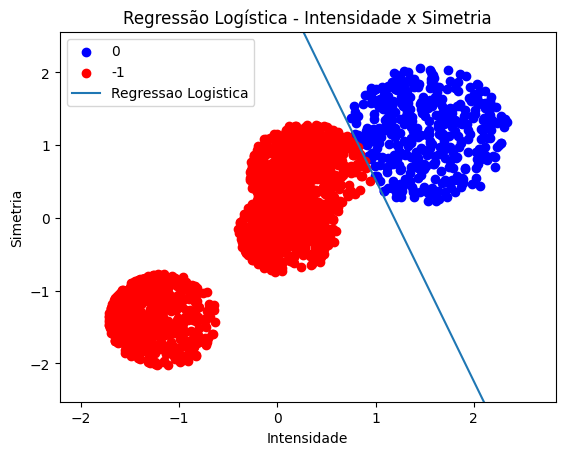

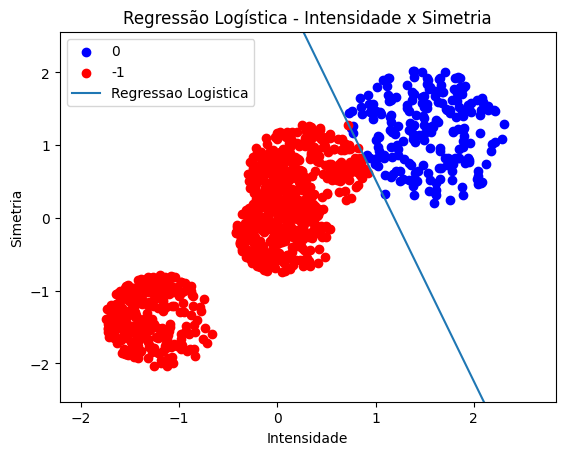

acuracia do digito 1: 100.0


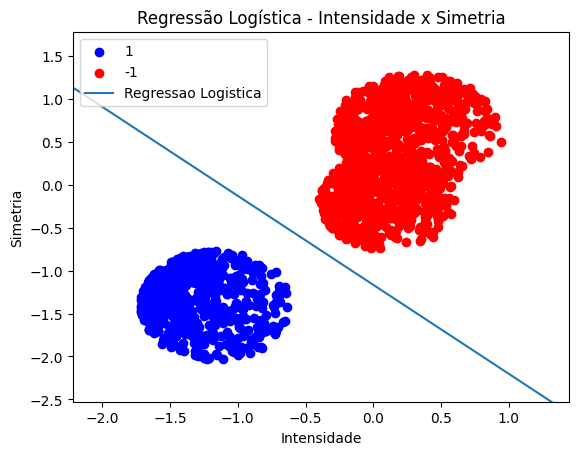

IndexError: boolean index did not match indexed array along dimension 0; dimension is 905 but corresponding boolean dimension is 1115

In [62]:
digitos = [0,1,4]
w_treino_list = classificador_de_todos_os_digitos_treinamento_Rlog(X, Y, X_teste, y_teste, digitos)
w_treino_list


# Usando a Regressão Linear

### Treinando o modelo

In [8]:
def classificador_de_todos_os_digitos_treinamento(X_treino,Y_treino,  X_teste, Y_teste, lista_digitos, modelo_reg):
    X = X_treino.copy()
    y = Y_treino.copy()
    x_teste = X_teste.copy()
    y_teste = Y_teste.copy()
    #modelo_reg = md.RegressaoLinear()

    for digito in lista_digitos:     
        y_binario_treino = np.where(y == digito, 1, -1)
        y_binario_teste = np.where(y_teste == digito, 1, -1)

        #treinando o modelo com os dados de treino
        w = modelo_reg.fit(X, y_binario_treino)
        y_pred_treino = modelo_reg.atribuicao_de_classes(X) 
        #utilizando os dados de teste com o w encontrado no treino
        y_pred_teste = modelo_reg.atribuicao_de_classes(x_teste)

        # Relatorio do treino
        print('Digito:', digito)
        print('Acuracia do treino:', modelo_reg.calculate_accuracy(y_pred_treino, y_binario_treino))
        print('Matriz de confusão do treino, os valores do digito estao na linha de baixo')
        matriz_de_confusao_treino = confusion_matrix(y_binario_treino, y_pred_treino)
        print(matriz_de_confusao_treino)
        print(classification_report(y_binario_treino, y_pred_treino, target_names=[f'{digito}', '-1']))
        # Gráfico do treino
        print('Gráfico de treino')
        modelo_reg.plot_grafico(X, y_pred_treino, digito, -1)

        # Relatório do teste
        print('Digito:', digito)
        print('Acuracia do teste:', modelo_reg.calculate_accuracy(y_pred_teste, y_binario_teste))
        matriz_de_confusao_teste = confusion_matrix(y_binario_teste, y_pred_teste)
        print(matriz_de_confusao_teste)
        print(classification_report(y_binario_teste, y_pred_teste, target_names=[f'{digito}', '-1']))
        print('Gráfico de teste')
        # plotando o gráfico de teste
        modelo_reg.plot_grafico(x_teste, y_pred_teste, digito, -1)
        

        # obtenha o indice dos valores de y_pred_treino que são 1 e retirando os elementos correspondentes em X e Y
        indices = np.where(y_pred_treino == 1)[0]
        X = np.delete(X, indices, axis=0)
        y = np.delete(y, indices, axis=0)
        indices_teste = np.where(y_pred_teste == 1)[0]
        x_teste = np.delete(x_teste, indices_teste, axis=0)
        y_teste = np.delete(y_teste, indices_teste, axis=0)




Digito: 0
Acuracia do treino: 95.28819762122598
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1761    0]
 [ 103  322]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1761
          -1       1.00      0.76      0.86       425

    accuracy                           0.95      2186
   macro avg       0.97      0.88      0.92      2186
weighted avg       0.96      0.95      0.95      2186

Gráfico de treino


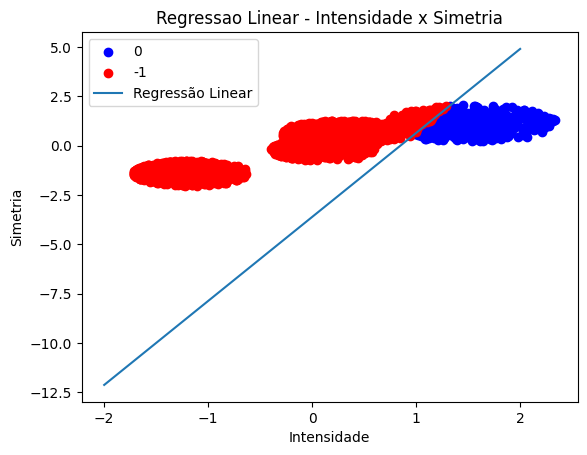

Digito: 0
Acuracia do teste: 96.05381165919282
[[897   0]
 [ 44 174]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       897
          -1       1.00      0.80      0.89       218

    accuracy                           0.96      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.96      0.96      0.96      1115

Gráfico de teste


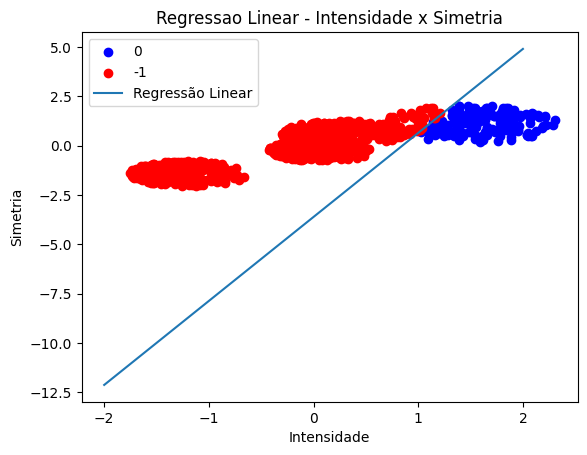

Digito: 1
Acuracia do treino: 100.0
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1256    0]
 [   0  608]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1256
          -1       1.00      1.00      1.00       608

    accuracy                           1.00      1864
   macro avg       1.00      1.00      1.00      1864
weighted avg       1.00      1.00      1.00      1864

Gráfico de treino


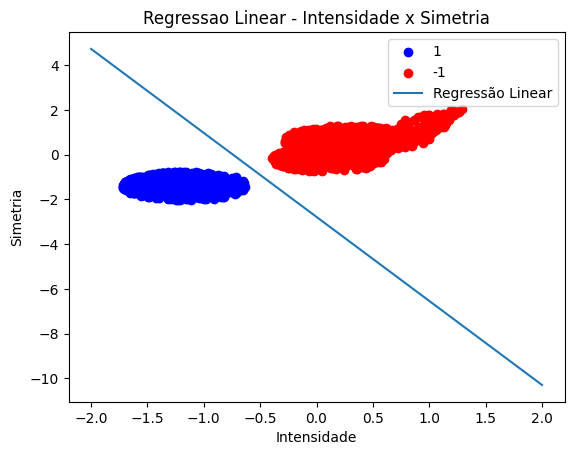

Digito: 1
Acuracia do teste: 100.0
[[649   0]
 [  0 292]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       649
          -1       1.00      1.00      1.00       292

    accuracy                           1.00       941
   macro avg       1.00      1.00      1.00       941
weighted avg       1.00      1.00      1.00       941

Gráfico de teste


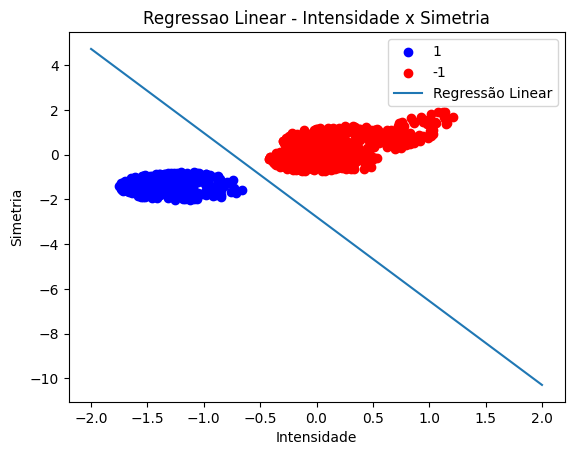

Digito: 4
Acuracia do treino: 92.67515923566879
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[603  76]
 [ 16 561]]
              precision    recall  f1-score   support

           4       0.97      0.89      0.93       679
          -1       0.88      0.97      0.92       577

    accuracy                           0.93      1256
   macro avg       0.93      0.93      0.93      1256
weighted avg       0.93      0.93      0.93      1256

Gráfico de treino


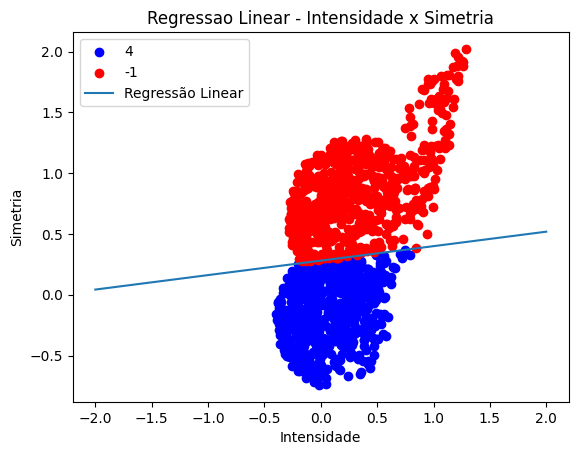

Digito: 4
Acuracia do teste: 94.60708782742681
[[303  32]
 [  3 311]]
              precision    recall  f1-score   support

           4       0.99      0.90      0.95       335
          -1       0.91      0.99      0.95       314

    accuracy                           0.95       649
   macro avg       0.95      0.95      0.95       649
weighted avg       0.95      0.95      0.95       649

Gráfico de teste


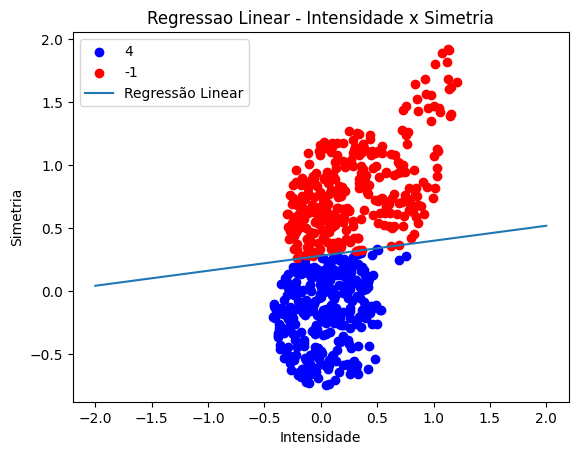

In [54]:
digitos = [0,1,4]
modelo = md.RegressaoLinear()
classificador_de_todos_os_digitos_treinamento(X, Y, X_teste, y_teste, digitos, modelo)



# Usando Perceptron

Digito: 0
Acuracia do treino: 97.94144556267155
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1761    0]
 [  45  380]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1761
          -1       1.00      0.89      0.94       425

    accuracy                           0.98      2186
   macro avg       0.99      0.95      0.97      2186
weighted avg       0.98      0.98      0.98      2186

Gráfico de treino


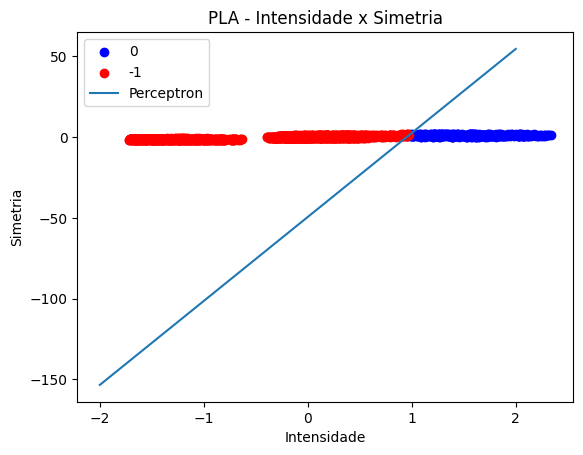

Digito: 0
Acuracia do teste: 98.02690582959642
[[897   0]
 [ 22 196]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       897
          -1       1.00      0.90      0.95       218

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Gráfico de teste


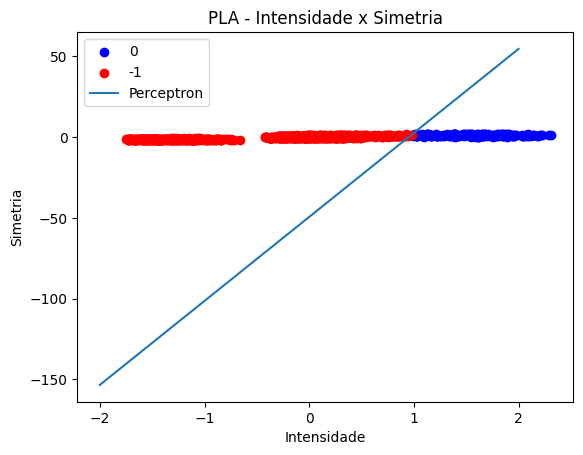

Digito: 1
Acuracia do treino: 100.0
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[1198    0]
 [   0  608]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1198
          -1       1.00      1.00      1.00       608

    accuracy                           1.00      1806
   macro avg       1.00      1.00      1.00      1806
weighted avg       1.00      1.00      1.00      1806

Gráfico de treino


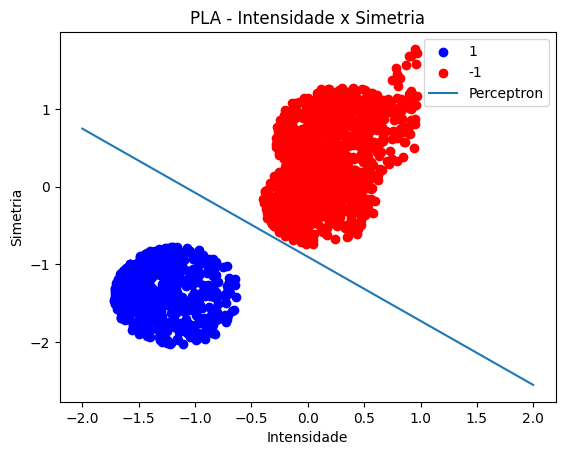

Digito: 1
Acuracia do teste: 100.0
[[627   0]
 [  0 292]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       627
          -1       1.00      1.00      1.00       292

    accuracy                           1.00       919
   macro avg       1.00      1.00      1.00       919
weighted avg       1.00      1.00      1.00       919

Gráfico de teste


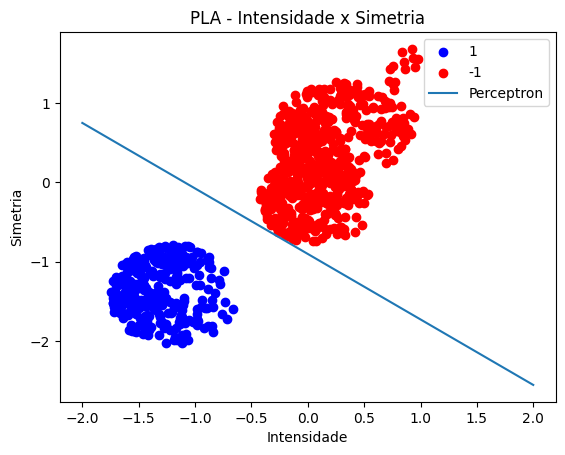

Digito: 4
Acuracia do treino: 82.0534223706177
Matriz de confusão do treino, os valores do digito estao na linha de baixo
[[621   0]
 [215 362]]
              precision    recall  f1-score   support

           4       0.74      1.00      0.85       621
          -1       1.00      0.63      0.77       577

    accuracy                           0.82      1198
   macro avg       0.87      0.81      0.81      1198
weighted avg       0.87      0.82      0.81      1198

Gráfico de treino


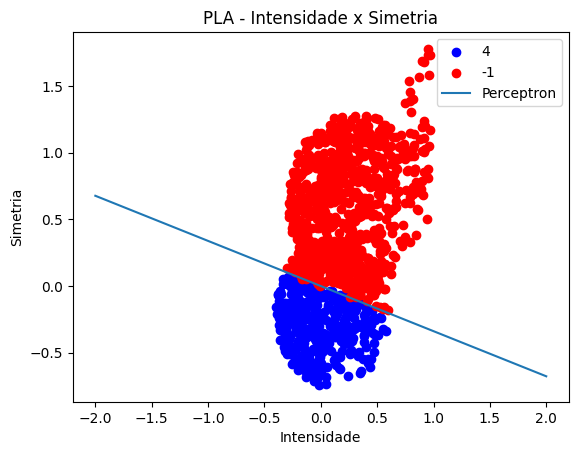

Digito: 4
Acuracia do teste: 83.73205741626795
[[313   0]
 [102 212]]
              precision    recall  f1-score   support

           4       0.75      1.00      0.86       313
          -1       1.00      0.68      0.81       314

    accuracy                           0.84       627
   macro avg       0.88      0.84      0.83       627
weighted avg       0.88      0.84      0.83       627

Gráfico de teste


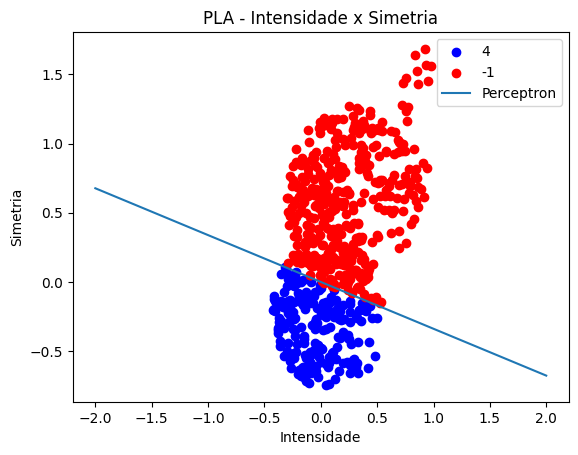

In [ ]:
digitos = [0,1,4]
modelo = md.PLA()
classificador_de_todos_os_digitos_treinamento(X, Y, X_teste, y_teste, digitos, modelo)